In [125]:
import sys
sys.path.append('/Users/jnimoca/Jose_BI/ashlar/ashlar/')
from ashlar import fileseries, thumbnail,reg
from ashlar.reg import plot_edge_shifts, plot_edge_quality, plot_edge_scatter

from ashlar.reg import BioformatsReader
from ashlar.reg import PyramidWriter
from ashlar.viewer import view_edges
# from ashlar.scripts.ashlar import process_axis_flip
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import networkx as nx
import matplotlib.patches as mpatches

import argparse
import numpy as np
import pandas as pd
# import pims
import napari
import os
from plotly import express as px
import plotly.io as pio
import kaleido
import skimage
import time
from os.path import abspath
def get_datetime():
    return time.strftime("%Y%m%d_%H%M%S")

import loguru
from loguru import logger



In [2]:
logger.remove()
logger.add(sys.stderr,                      format="<green>{time:HH:mm:ss.SS}</green> | <level>{level}</level> | {message}")
logger.add(f"../logs/{get_datetime()}_ashlar.log",  format="{time:YYYYMMDD HHmmss} | <level>{level}</level> | {message}")

#example logging usage
# logger.debug("That's it, folks!")
# logger.info("I'm sorry, Dave. I'm afraid I can't do that.")
# logger.warning("I am warning you")
# logger.error("I am error")
# logger.critical("I am critical")

2

In [3]:
fileseries_params = {
    'overlap': 0.5,
    'width': 9,
    'height': 9,
    'layout': 'snake',
    'direction': 'horizontal',
    'pixel_size': 0.17,
}

## Step 1.1: Load files function

In [4]:
def load_images(path_to_images, series:bool=False, fileseries_pattern:str=None, cycle_ids:list=None, fileseries_kwargs:dict=None) -> list:
    """
    Parameters:
    path_to_images: str
        Path to the images to be loaded
    series: bool
        If True, load images as a fileseries
    fileseries_pattern: str
        The fileseries pattern to use when loading images
        examples:
        'cycle{i}_core0001_tile{{series}}.nd2' <- Double curly braces are used to escape the format string
    """
    logger.info(f"Loading images from {path_to_images}")

    readers = []

    if series:
        logger.info("Loading images as a fileseries")
        assert fileseries_pattern is not None, "Please provide a fileseries string"
        assert cycle_ids is not None, "Please provide a list of cycle ids"
        
        logger.info(f"Cycle {cycle_ids[0]} will be reference cycle")
        logger.info(f"Cycles {cycle_ids[1:]} will be aligned to reference cycle")
        for cycle_id in cycle_ids:
            logger.info(f"Loading cycle {cycle_id}")
            readers.append(
                fileseries.FileSeriesReader(
                    path_to_images,
                    pattern=fileseries_pattern.format(i=cycle_id),
                    overlap=fileseries_kwargs['overlap'],
                    width=fileseries_kwargs['width'],
                    height=fileseries_kwargs['height'],
                    layout=fileseries_kwargs['layout'],
                    direction=fileseries_kwargs['direction'],
                    pixel_size=fileseries_kwargs['pixel_size'],
                )
            )

    else:
        #TODO natural sorting of files
        logger.info("Loading each image as a cycle")
        #list of all files with absolute paths in the directory
        list_of_images = os.listdir(path_to_images)
        list_of_images = [abspath(os.path.join(path_to_images, f)) for f in list_of_images if os.path.isfile(os.path.join(path_to_images, f))]
        logger.info(f"Found {len(list_of_images)} images in {path_to_images}")

        for i, path_to_cycle in enumerate(list_of_images):
            logger.info(f"Loading cycle {i} from file: {path_to_cycle}")
            readers.append(BioformatsReader(path_to_cycle))

    logger.success("Images loaded successfully")
    return readers

 ## Step 1.2: Load files tests 

In [5]:
readers = load_images(path_to_images="/Users/jnimoca/Jose_BI/data/raw/raw_cycles")

11:16:43.55 | INFO | Loading images from /Users/jnimoca/Jose_BI/data/raw/raw_cycles
11:16:43.55 | INFO | Loading each image as a cycle
11:16:43.55 | INFO | Found 3 images in /Users/jnimoca/Jose_BI/data/raw/raw_cycles
11:16:43.55 | INFO | Loading cycle 0 from file: /Users/jnimoca/Jose_BI/data/raw/raw_cycles/exemplar-001-cycle-08.ome.tiff
11:16:44.09 | INFO | Loading cycle 1 from file: /Users/jnimoca/Jose_BI/data/raw/raw_cycles/exemplar-001-cycle-07.ome.tiff
11:16:44.13 | INFO | Loading cycle 2 from file: /Users/jnimoca/Jose_BI/data/raw/raw_cycles/exemplar-001-cycle-06.ome.tiff
11:16:44.16 | SUCCESS | Images loaded successfully


In [16]:
readers_fileseries = load_images(
    path_to_images="/Users/jnimoca/Jose_BI/data/raw/raw_fileseries", 
    series=True, 
    fileseries_pattern='cycle{i}_core0001_tile{{series}}.nd2', 
    cycle_ids=["0000", "0001"], 
    fileseries_kwargs=fileseries_params)

11:18:05.52 | INFO | Loading images from /Users/jnimoca/Jose_BI/data/raw/raw_fileseries
11:18:05.52 | INFO | Loading images as a fileseries
11:18:05.52 | INFO | Cycle 0000 will be reference cycle
11:18:05.52 | INFO | Cycles ['0001'] will be aligned to reference cycle
11:18:05.52 | INFO | Loading cycle 0000
11:18:06.01 | INFO | Loading cycle 0001
11:18:06.25 | SUCCESS | Images loaded successfully


## Step 2.1: Perform alignment to each cycle

In [6]:
def align_cycles(readers, channel:int=0, max_shift:int=15, filter_sigma:int=0, save_path:str=None):
    """
    Align cycles and return a list of aligners and a DataFrame.

    Parameters:
        readers (list): List of BioformatsReader or FileSeriesReader objects.
        channel (int): Channel number.
        max_shift (int): Maximum shift allowed.
        filter_sigma (int): Sigma value for filtering.

    Returns:
        tuple: A list of aligners and a DataFrame with alignment data.
    """

    logger.info("Aligning cycles")
    
    aligners = []
    df = pd.DataFrame(columns=["edge_id", "cycle_id", "X_Error", "Y_Shift"])

    for i, reader in enumerate(readers):
        logger.info(f"Aligning cycle {i}")
        aligner = reg.EdgeAligner(reader, channel=channel, max_shift=max_shift, filter_sigma=filter_sigma)
        aligner.run()
        logger.debug(f"Cycle {i} aligned successfully")
        
        #append values to dataframe
        tmp_df = pd.DataFrame(
            data = {
                "edge_id": np.array([f"({x[0]},{x[1]})" for x in np.array(aligner.neighbors_graph.edges)]).ravel(),
                "cycle_id": f"cycle_{str(i).zfill(2)}",
                'X_Error': np.clip(aligner.all_errors, 0, 10),
                'Y_Shift': np.clip([np.linalg.norm(v[0]) for v in aligner._cache.values()], 0.01, np.inf)
            }
        )

        logger.debug(f"tmp.df shape {tmp_df.shape} rows to dataframe")
        df = pd.concat([df, tmp_df], ignore_index=True)
        aligners.append(aligner)

    if save_path is not None:
        logger.info(f"Saving alignment data to {save_path}")
        df.to_csv(save_path, index=False)
    
    logger.success("Finished aligning cycles")
    return aligners, df

## Step 2.2 Test Alignment Cycles

In [7]:
aligners, df = align_cycles(readers, channel=0, max_shift=30, filter_sigma=1)

11:16:55.88 | INFO | Aligning cycles
11:16:55.88 | INFO | Aligning cycle 0


    assembling thumbnail 6/6

/opt/homebrew/Caskroom/mambaforge/base/envs/ashlar/lib/python3.10/site-packages/ashlar/reg.py:1367: DataWarning: Stage coordinates' measurement unit is undefined; assuming μm.
  warnings.warn(message, DataWarning)


11:16:56.52 | DEBUG | Cycle 0 aligned successfully
11:16:56.52 | DEBUG | tmp.df shape (7, 4) rows to dataframe
/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_52928/1759171934.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, tmp_df], ignore_index=True)
11:16:56.52 | INFO | Aligning cycle 1


    assembling thumbnail 6/6

/opt/homebrew/Caskroom/mambaforge/base/envs/ashlar/lib/python3.10/site-packages/ashlar/reg.py:1367: DataWarning: Stage coordinates' measurement unit is undefined; assuming μm.
  warnings.warn(message, DataWarning)


11:16:57.11 | DEBUG | Cycle 1 aligned successfully
11:16:57.11 | DEBUG | tmp.df shape (7, 4) rows to dataframe
11:16:57.11 | INFO | Aligning cycle 2


    assembling thumbnail 6/6

/opt/homebrew/Caskroom/mambaforge/base/envs/ashlar/lib/python3.10/site-packages/ashlar/reg.py:1367: DataWarning: Stage coordinates' measurement unit is undefined; assuming μm.
  warnings.warn(message, DataWarning)


11:16:57.74 | DEBUG | Cycle 2 aligned successfully
11:16:57.74 | DEBUG | tmp.df shape (7, 4) rows to dataframe
11:16:57.74 | SUCCESS | Finished aligning cycles


In [113]:
aligners_fileseries, df_fileseries = align_cycles(readers_fileseries, channel=0, max_shift=30, filter_sigma=1) 
#5m42s with max15
#8m37s with max30

13:07:32.84 | INFO | Aligning cycles
13:07:32.85 | INFO | Aligning cycle 0


    assembling thumbnail 81/81


/opt/homebrew/Caskroom/mambaforge/base/envs/ashlar/lib/python3.10/site-packages/ashlar/reg.py:1367: DataWarning:

Some neighboring tiles have zero overlap.

13:11:43.58 | DEBUG | Cycle 0 aligned successfully
13:11:43.59 | DEBUG | tmp.df shape (398, 4) rows to dataframe
/var/folders/x7/grkjlk8s223dy6234rnz1885mxz2_6/T/ipykernel_52928/1759171934.py:37: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

13:11:43.59 | INFO | Aligning cycle 1


    assembling thumbnail 81/81


/opt/homebrew/Caskroom/mambaforge/base/envs/ashlar/lib/python3.10/site-packages/ashlar/reg.py:1367: DataWarning:

Some neighboring tiles have zero overlap.

13:16:09.78 | DEBUG | Cycle 1 aligned successfully
13:16:09.80 | DEBUG | tmp.df shape (398, 4) rows to dataframe
13:16:09.80 | SUCCESS | Finished aligning cycles


## Step 3 Plot Aligners

In [8]:
def plot_scatter_shift_error(df:pd.DataFrame, save_path:str=None):

    fig = px.scatter(df, x='X_Error', y='Y_Shift', color='cycle_id', hover_data=['edge_id'])

    fig.update_layout(
        title='Error vs Shift', 
        height=800,width=1200,
        paper_bgcolor="white", plot_bgcolor="white",
        uniformtext_minsize=12, uniformtext_mode='hide')

    fig.update_yaxes(
        type="log", nticks=7, 
        showline=True, linecolor="black", mirror=True,
        title=dict(
            text='Shift distance (pixels)',
            font=dict(
                family='Arial',
                size=18,
                color='black')))

    fig.update_xaxes(
        showline=True, linecolor="black", mirror=True,
        title=dict(
            text='Error (NCC)', 
            font=dict(
                family='Arial',
                size=18,
                color='black')))

    fig.update_traces(
        marker=dict(
            size=8, 
            opacity=0.6, 
            line=dict(
                width=1, 
                color='DarkSlateGrey')))
    
    if save_path is not None:
        logger.info(f"Saving scatter plot to {save_path}")
        fig.write_image(save_path.rsplit(".", 1)[0] + ".png")
        fig.write_html(save_path)

    return fig

In [114]:
plot_scatter_shift_error(df, save_path="../figures/scatter_shift_error.html")

13:16:09.97 | INFO | Saving scatter plot to ../figures/scatter_shift_error.html


In [115]:
plot_scatter_shift_error(df_fileseries, save_path="../figures/20240410_1316_scatter_shift_error.html")

13:16:47.73 | INFO | Saving scatter plot to ../figures/20240410_1316_scatter_shift_error.html


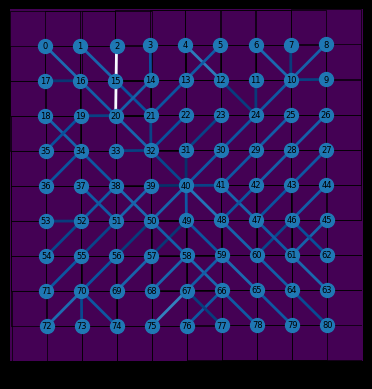

In [120]:
plot_edge_shifts(aligners_fileseries[0])

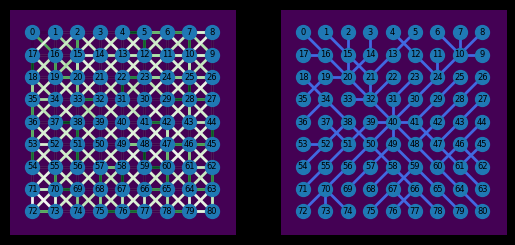

In [124]:
plot_edge_quality(aligners_fileseries[0])

/opt/homebrew/Caskroom/mambaforge/base/envs/ashlar/lib/python3.10/site-packages/ashlar/reg.py:1469: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/opt/homebrew/Caskroom/mambaforge/base/envs/ashlar/lib/python3.10/site-packages/ashlar/reg.py:1472: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




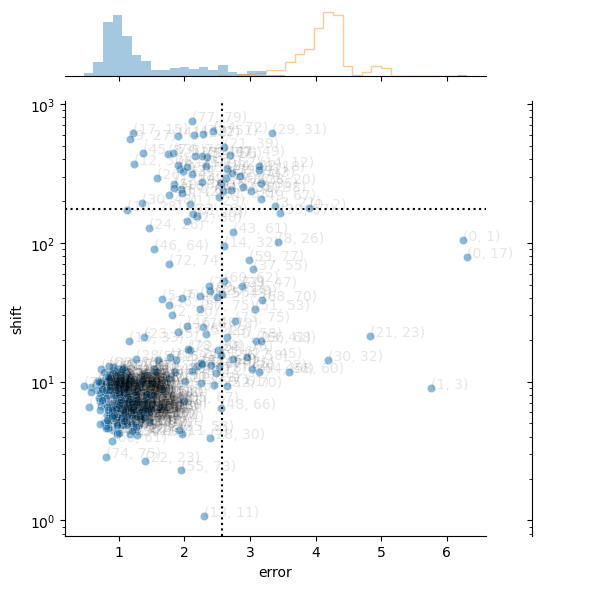

In [126]:
plot_edge_scatter(aligners_fileseries[0])